imports done, countovectorizing...
1
(5000, 2000)
2
3
4
(5000, 1960)
5
done, plotting....


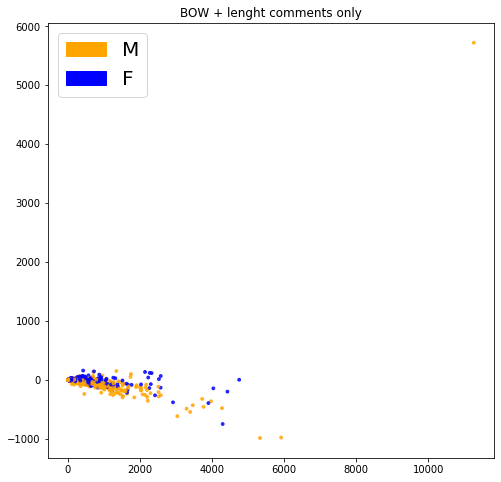

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 105.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 172.3min finished


xgbCLf.best_score =  0.8425215483825477
xgbCLf.best_estimator_ =  XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.8, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             objective='reg:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='gpu_hist', validate_parameters=False, verbosity=None)
CPU times: user 1min, sys: 14.5 s, total: 1min 14s
Wall time: 2h 53min 29s


In [2]:
%%time

import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import joblib
 
    
# load preprocessed data to save tine
with open("../input/challengedadata/comments.txt", "rb") as f:
    clean_train_comments = pickle.load(f) 
    f.close()

with open("../input/challengedadata/targets.txt", "rb") as ft:
    y = pickle.load(ft) 
    ft.close()
    
print("imports done, countovectorizing...")

vectorizer = CountVectorizer(analyzer = "word",
                             max_features = 2000, ngram_range=(1, 2)) 
# converts in np array
train_data_features = vectorizer.fit_transform(clean_train_comments).toarray()

print("1")
print(train_data_features.shape)
# print vocabulary 
print("2")
vocab = vectorizer.get_feature_names()

print("3")
# counts how many times a word appearco
dist = np.sum(train_data_features, axis=0)

print("4")
    # removes the 40 most utilized words
for _ in range(40):
    index = np.argmax(dist)
    train_data_features = np.delete(train_data_features, index, axis = 1)
    
print(train_data_features.shape)

# np array
X_len = [[len(x)] for x in train_data_features] 
print("5")
s = np.concatenate((train_data_features,np.array(X_len)),axis = 1)

# 5000 rows (one per author),  and 2000-40+1 (X_len) features
s.shape

# un np.array
y = np.array(y)    
    
print("done, plotting....")


# plot along the two dimensions with most variance

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='M')
            blue_patch = mpatches.Patch(color='blue', label='F')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})
            plt.title('BOW + lenght comments only')
            plt.savefig('foo.pdf')

fig = plt.figure(figsize=(8, 8))          
plot_LSA(train_data_features, y)
plt.show()    
    

parameters = {"learning_rate":[0.03,0.05,0.07,0.01,0.15,0.2,0.25,0.3],'min_child_weight': [1,4,5,8],'gamma': [0.0, 0.1,0.2, 0.3,0.4,0.5,0.6,0.8],
               'subsample': [0.6,0.7,0.8,0.9,1], 'colsample_bytree': [0.3,0.4,0.5, 0.6,0.7,0.8,0.9,1],
               'max_depth': [2,3,4,5,6,7,8,10,12,15], 'scale_pos_weight': [1,2.70, 10, 25, 50, 75, 100, 1000] }

parameters0 = {'min_child_weight': [1,8],'gamma': [0.6,0.8],
               'subsample': [0.9], 'colsample_bytree': [0.6],
               'max_depth': [4], 'scale_pos_weight': [1,2.70, 10, 25, 50, 75, 100, 1000] }

    
xgb = XGBRegressor(objective = "reg:logistic", n_estimators=10000, 
                 tree_method = "gpu_hist", gpu_id = 0)


# Model exploration
xgbClf = GridSearchCV(xgb, param_grid = parameters0, cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001), scoring = "roc_auc" ,verbose=True, n_jobs=-1)

# Model fit
xgbClf.fit(s, y, verbose=False)

# Save model
joblib.dump(xgbClf, '../working/xgbClf.pkl')

print("xgbCLf.best_score = ", xgbClf.best_score_)
print("xgbCLf.best_estimator_ = ", xgbClf.best_estimator_)